<a href="https://colab.research.google.com/github/mkhfring/cosc419-notes/blob/main/week5/name-generation%20(bigram%20part%202).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial is inspired by [A Neural Probabilistic Language Model Paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-10-25 04:55:28--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2024-10-25 04:55:28 (5.00 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
block_size = 3 # context length: how many characters do we take to predict the next one?

X, Y = [], []
for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)



emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [11]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [12]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [16]:
C = torch.randn((27,2))

Let's embed character number 5. We have two options. Following code cells indicate this procedure.

In [17]:
C[5]

tensor([-0.4209,  1.2852])

In [19]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.4209,  1.2852])

As one can see, the result is the same because of the way that matrix multiplication works

Since working with the index of the lookup table is faster and more efficient, we ignore one-hot encoding. We saw how we can convert a character indexed as 5 into an embedding. Now, we aim to convert all the input characters into embeddings. The next code cells show how we can do so:

In [20]:
C[[5,6,7]]

tensor([[-0.4209,  1.2852],
        [-0.8882,  0.4404],
        [ 0.8683,  1.0261]])

In [21]:
C[torch.tensor([5,6,7])]

tensor([[-0.4209,  1.2852],
        [-0.8882,  0.4404],
        [ 0.8683,  1.0261]])

Pytorch can also accept a multi-dimentional tensor as follows:

In [22]:
C[X].shape

torch.Size([32, 3, 2])

In [23]:
X.shape

torch.Size([32, 3])

In [25]:
X[13, 2]

tensor(1)

In [26]:
C[X[13, 2]]

tensor([-0.6361, -0.1072])

In [27]:
C[1]

tensor([-0.6361, -0.1072])

In [48]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

Now, let's create the first hidden layer of the neural network.

In [29]:
w1 = torch.randn(6, 100)
b1 = torch.randn(100)

The aim is to calculate emb @ w1 + b1. However, this doesn’t work because the dimensions of the input are (3, 2), and the first dimension of the first layer is 6. To solve this issue, we need to somehow concatenate the inputs and feed them to the first layer.

In [37]:
a = torch.tensor([1, 2, 3, 4, 5, 6])
a

tensor([1, 2, 3, 4, 5, 6])

Using view is an efficient way to change the shape of a tensor.


In [45]:
a.view(3,2)

tensor([[1, 2],
        [3, 4],
        [5, 6]])

In [46]:
a.storage()

 1
 2
 3
 4
 5
 6
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 6]

In [49]:
emb.view(32, 6)

tensor([[-1.7559, -2.1912, -1.7559, -2.1912, -1.7559, -2.1912],
        [-1.7559, -2.1912, -1.7559, -2.1912, -0.4209,  1.2852],
        [-1.7559, -2.1912, -0.4209,  1.2852, -0.6203,  0.3938],
        [-0.4209,  1.2852, -0.6203,  0.3938, -0.6203,  0.3938],
        [-0.6203,  0.3938, -0.6203,  0.3938, -0.6361, -0.1072],
        [-1.7559, -2.1912, -1.7559, -2.1912, -1.7559, -2.1912],
        [-1.7559, -2.1912, -1.7559, -2.1912, -0.3671, -1.4018],
        [-1.7559, -2.1912, -0.3671, -1.4018,  0.1889,  0.0231],
        [-0.3671, -1.4018,  0.1889,  0.0231,  0.8458, -1.1565],
        [ 0.1889,  0.0231,  0.8458, -1.1565, -0.5150, -0.2671],
        [ 0.8458, -1.1565, -0.5150, -0.2671,  0.8458, -1.1565],
        [-0.5150, -0.2671,  0.8458, -1.1565, -0.6361, -0.1072],
        [-1.7559, -2.1912, -1.7559, -2.1912, -1.7559, -2.1912],
        [-1.7559, -2.1912, -1.7559, -2.1912, -0.6361, -0.1072],
        [-1.7559, -2.1912, -0.6361, -0.1072, -0.5150, -0.2671],
        [-0.6361, -0.1072, -0.5150, -0.2

In [50]:
emb.view(32, 6) @ w1 + b1

tensor([[-3.1084e+00,  5.5319e+00,  4.0693e+00,  ...,  7.4842e+00,
         -2.8841e+00,  1.6741e+00],
        [-3.8451e+00,  1.0896e+00,  2.4073e+00,  ...,  4.6435e+00,
         -5.0361e+00,  7.3126e+00],
        [-2.2679e-02,  3.1335e+00, -8.6743e-02,  ...,  1.7135e+00,
          2.8864e+00,  8.4936e+00],
        ...,
        [-4.7647e+00,  3.1796e+00,  3.1012e+00,  ...,  4.3302e+00,
         -6.8076e-01,  3.9395e+00],
        [-7.1727e-01, -2.6059e+00, -2.7488e+00,  ...,  1.7161e+00,
         -6.9795e-01,  3.0630e-01],
        [ 8.6087e-01,  3.0129e-03,  3.2750e+00,  ...,  3.3300e+00,
         -1.7271e+00,  1.9423e-01]])

In [51]:
 h  = emb.view(32, 6) @ w1 + b1
 h.shape

torch.Size([32, 100])

In [53]:
 h  = torch.tanh(emb.view(-1, 6) @ w1 + b1)
 h

tensor([[-0.9960,  1.0000,  0.9994,  ...,  1.0000, -0.9938,  0.9321],
        [-0.9991,  0.7967,  0.9839,  ...,  0.9998, -0.9999,  1.0000],
        [-0.0227,  0.9962, -0.0865,  ...,  0.9371,  0.9938,  1.0000],
        ...,
        [-0.9999,  0.9965,  0.9960,  ...,  0.9997, -0.5920,  0.9992],
        [-0.6152, -0.9892, -0.9918,  ...,  0.9374, -0.6031,  0.2971],
        [ 0.6967,  0.0030,  0.9971,  ...,  0.9974, -0.9387,  0.1918]])

In [54]:
h.shape

torch.Size([32, 100])

In [55]:
w2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [57]:
logits = h @ w2 + b2
logits.shape

torch.Size([32, 27])

In [58]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs.shape

torch.Size([32, 27])

In [59]:
probs[0].sum()

tensor(1.)

In [61]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(15.1441)

In [75]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6 , 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [64]:
# Forward pass
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

Exponentiating the logits and then computing probabilities is called cross-entropy. Instead of performing these calculations manually, we can simply call the cross_entropy function from F in PyTorch as follows:

In [66]:
F.cross_entropy(logits, Y)

tensor(17.7697)

In [79]:
for _ in range(10000):
  # Forward pass
  emb = C[X]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdims=True)
  # loss = -probs[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Y)
  print(loss.item())
  # Backward pass
  for p in parameters:
    p.grad = None

  loss.backward()
  for p in parameters:
    p.data -= 0.1 * p.grad

Streaming output truncated to the last 5000 lines.
0.252274751663208
0.25227439403533936
0.25227439403533936
0.2522740364074707
0.2522740662097931
0.25227370858192444
0.25227370858192444
0.2522733509540558
0.25227341055870056
0.2522730231285095
0.2522730529308319
0.25227269530296326
0.25227269530296326
0.252272367477417
0.252272367477417
0.2522720396518707
0.25227200984954834
0.25227171182632446
0.25227171182632446
0.2522713541984558
0.2522713541984558
0.25227105617523193
0.25227102637290955
0.25227072834968567
0.2522706985473633
0.252270370721817
0.25227034091949463
0.25227004289627075
0.25227007269859314
0.2522697150707245
0.2522696852684021
0.2522693872451782
0.2522693872451782
0.25226905941963196
0.25226908922195435
0.2522687315940857
0.2522687315940857
0.25226840376853943
0.25226840376853943
0.2522680461406708
0.25226807594299316
0.2522677481174469
0.2522677481174469
0.25226736068725586
0.25226739048957825
0.252267062664032
0.252267062664032
0.2522667348384857
0.2522667348384857
0

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

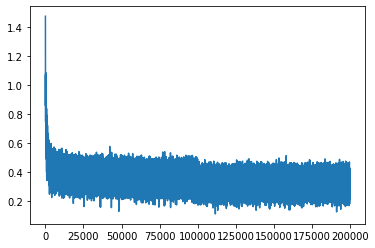

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1335, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1635, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1637, grad_fn=<NllLossBackward0>)

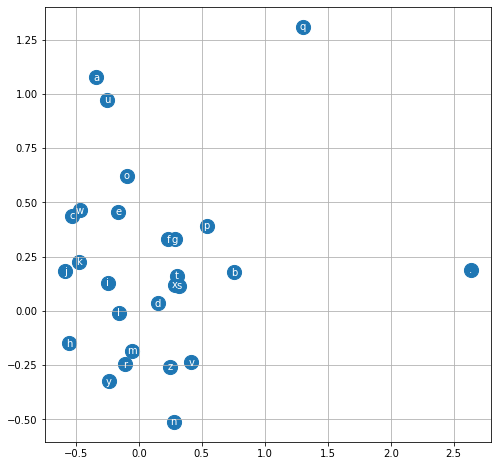

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carmah.
ambril.
khi.
mili.
thylahnanden.
jazhnen.
deliah.
jareei.
ner.
kentzeriiv.
kaleigh.
ham.
jory.
quint.
shon.
marian.
quinteron.
jarynn.
jaxen.
dus.
